In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, converters
from numpy import pi
from math import floor, log2


In [78]:
N = 15 # Number we want to factor
L = floor(log2(N) + 1)  # Number of bits needed to represent N
print(L)
epsilon = .02 # todo idk what this is
t = 2*L + 1 + floor(1 + log2(2 + 1/(2*epsilon)))  # formula from nielsen for required qbits
print(t)

4
14


In [270]:
# blatantly stole qft circuit generator from this:
# https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

# stolen from https://quantumcomputing.stackexchange.com/questions/29647/trying-to-construct-modular-exponentiation-gate-in-qiskit
# todo need to actually implement something.
# Basically, fix N (number to factor) and create modexp gate based on that.
# lucky me this code is for 15 lol ggez
# fixme uhh control
def c_7mod15_gate(power):

    U = QuantumCircuit(4)
    # https://quantumcomputing.stackexchange.com/questions/15280/how-does-this-represent-modular-multiplication

    for _ in range(power):
      U.x(range(4))
      U.swap(1, 2)
      U.swap(2, 3)
      U.swap(0, 3)

    U = U.to_gate()
    U.name = "%i^%i mod 15" % (7, power)
    c_U = U.control() ##.control(t)
    return c_U

def modexp(circuit, n):
   pass

def modexp_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "QFT"
  modexp(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate


In [271]:
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city

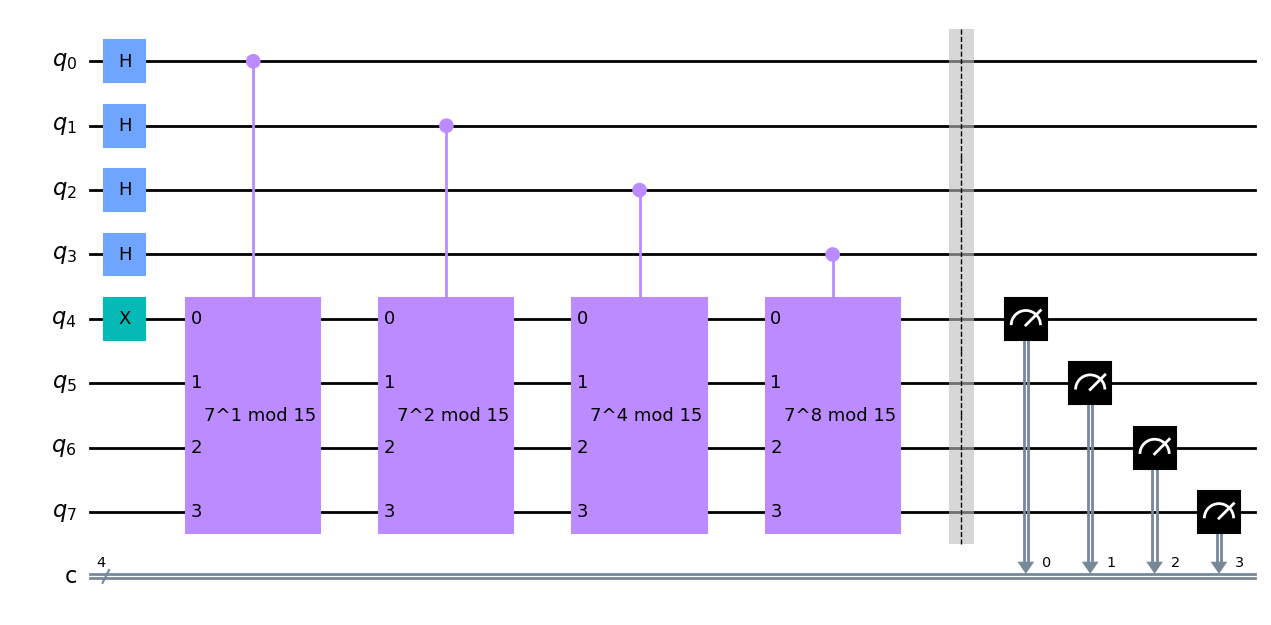

In [279]:
circ = QuantumCircuit(8, 4)

circ.h(range(4))


gate1 = c_7mod15_gate(1)
gate2 = c_7mod15_gate(2)
gate4 = c_7mod15_gate(4)
gate8 = c_7mod15_gate(8)

circ.x(4)
#circ.x(1) #lsb
#[circ.x(i) for i in range(1, 5)]
circ.append(gate1, [0, 4, 5, 6, 7])
circ.append(gate2, [1, 4, 5, 6, 7])
circ.append(gate4, [2, 4, 5, 6, 7])
circ.append(gate8, [3, 4, 5, 6, 7])

#circ.append(qft_gate(4).inverse(), range(4))

circ.barrier(range(8))

circ.measure(range(4, 8), range(4))
circ.draw("mpl")

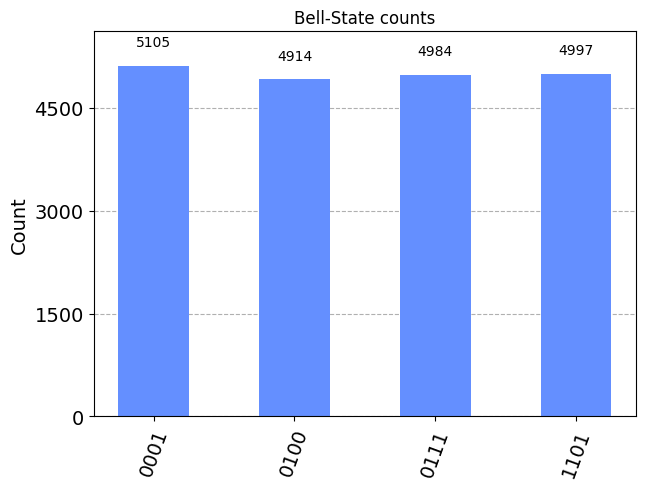

In [280]:
simulator = Aer.get_backend('aer_simulator')
transpiled_circ = transpile(circ, simulator)
result = simulator.run(transpiled_circ, shots=20000).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='Bell-State counts')
# ignore number on right i dont know how to do this without measure_all

In [281]:
# ok, This appears to work

In [282]:
# blatantly stole qft circuit generator from this:
# https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit

def qft_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "QFT"
  qft(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate

def inverse_qft_gate(n):
  qc = QuantumCircuit(n)
  qc.name = "InverseQFT"
  inverse_qft(qc, n)
  gate = converters.circuit_to_gate(qc)

  return gate


In [247]:

U.draw()

┌───┐                                   ┌───┐     
q_0: ┤ X ├────────────────────────────────■──┤ X ├──■──
     ├───┤     ┌───┐                      │  └─┬─┘  │  
q_1: ┤ X ├──■──┤ X ├──■───────────────────┼────┼────┼──
     ├───┤┌─┴─┐└─┬─┘┌─┴─┐     ┌───┐       │    │    │  
q_2: ┤ X ├┤ X ├──■──┤ X ├──■──┤ X ├──■────┼────┼────┼──
     ├───┤└───┘     └───┘┌─┴─┐└─┬─┘┌─┴─┐┌─┴─┐  │  ┌─┴─┐
q_3: ┤ X ├───────────────┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├
     └───┘               └───┘     └───┘└───┘     └───┘